In [1]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib.animation as animation

# Wind Field

In [165]:
dt = 60*29.5 # 15 minute
t_end = 86400 * 4 # 4 days
t = np.arange(0,t_end,dt)

# i and j index to 500
ilen = 100
i = np.arange(0,ilen,1)
i_half = np.arange(0.5,ilen,1)
j = np.arange(0,ilen,1)
j_half = np.arange(0.5,ilen,1)

dx = 5000
x = np.arange(-(len(i)*dx)/2,(len(i)*dx)/2 + dx,dx)
x_half = np.arange(-(len(i)*dx)/2,(len(i)*dx)/2 + dx,dx) + round(np.diff(x).mean())/2

dy = 5000
y = np.arange(-(len(j)*dy)/2,(len(j)*dy)/2 + dy,dy)
y_half = np.arange(-(len(j)*dy)/2,(len(j)*dy)/2 + dy,dy) + round(np.diff(y).mean())/2

u = np.zeros((len(i), len(j), len(t)))
v = np.zeros((len(i), len(j), len(t)))
h = np.zeros((len(i), len(j), len(t)))

tau_x = np.zeros((len(i), len(j), len(t)))
tau_y = np.zeros((len(i), len(j), len(t)))

In [166]:
rm = 50*1e3 # meters
r0 = 200e3
taum = 2
for I,value in enumerate(tau_x):
    for J,val in enumerate(value):
        for N,T in enumerate(val):
            time = t[N]
            if time <= 86400/2: # if T is less than 12 hours
                X = x[I]
                Y = y[J]
                R = np.sqrt(X**2+Y**2) # check if radius is less than r0
                if (R < r0) & (R >= rm): # if radius less than r0
                    coeff = (R - r0)/(R - r0)
                    tau = coeff * taum
                    theta = np.arctan2(Y,X)
                    taux = tau * -np.cos(theta)
                        
                    tau_x[I,J,N] = taux
                else:
                    # if radius is longer than r0, tau_x is 0
                    tau_x[I,J,N] = 0
            else:
                # if time is greater than 12 hours tau_x is 0
                tau_x[I,J,N] = 0
                
                
for I,value in enumerate(tau_y):
    for J,val in enumerate(value):
        for N,T in enumerate(val):
            time = t[N]
            if time <= 86400/2: # if T is less than 12 hours
                X = x[I]
                Y = y[J]
                R = np.sqrt(X**2+Y**2) # check if radius is less than r0
                if (R < r0) & (R >= rm): # if radius less than r0
                    coeff = (R - r0)/(R - r0)
                    tau = coeff * taum
                    theta = np.arctan2(Y,X)
                    tauy = tau * np.sin(theta)
                        
                    tau_y[I,J,N] = tauy
                else:
                    # if radius is longer than r0, tau_y is 0
                    tau_y[I,J,N] = 0
            else:
                # if time is greater than 12 hours tau_y is 0
                tau_y[I,J,N] = 0
                

# Grid A

In [207]:
dt = 60*15 # 15 minute
t_end = 86400 * 4 # 4 days
t = np.arange(0,t_end,dt)

# i and j index to 500
ilen = 100
i = np.arange(0,ilen,1)
j = np.arange(0,ilen,1)

dx = 5000
x_A = np.arange(-(len(i)*dx)/2,(len(i)*dx)/2 + dx,dx)


dy = 5000
y_A = np.arange(-(len(j)*dy)/2,(len(j)*dy)/2 + dy,dy)


u_A = np.zeros((len(i), len(j), len(t)))
v_A = np.zeros((len(i), len(j), len(t)))
h_A = np.zeros((len(i), len(j), len(t)))


In [208]:
gp = 9.8 * (1024-1020)/1024
H = 100
p = 1020
f = 10**(-4)
dx = 5000
dy = 5000
for n,T in enumerate(t):
    # print(T)
    for I,i_val in enumerate(i):
        for J,j_val in enumerate(j):
            if I < i.max():
                if n < len(t)-1:
                    if J < j.max():
                        
                        # SOLVING FOR U **************************************************
                        TAUX = (tau_x[J,I,n])     
                        # dhdx = (h_A[I+1,J,n] - h_A[I-1,J,n])/(2*dx)             # dhdx[i,j,n]
                        dhdx = (h_A[J,I+1,n] - h_A[J,I-1,n])/(2*dx)             # dhdx[i,j,n]
                        Vij = v_A[J,I,n]
                        # Vij = v_A[I,J,n]
                        # u_A[I,J,n+1] = (2 * -dt * gp * dhdx) + ((2*dt)/(H*p) * TAUX) + (Vij * f * dt*2) + u_A[I,J,n-1]
                        u_A[J,I,n+1] = (2 * -dt * gp * dhdx) + ((2*dt)/(H*p) * TAUX) + (Vij * f * dt*2) + u_A[J,I,n-1]
                    
                        # SOLVING FOR V **************************************************
                        TAUY = (tau_y[J,I,n])
                        # dhdy = (h_A[I,J+1,n] - h_A[I,J-1,n])/(2*dy)             # dhdy[i,j+1/2,n]
                        dhdy = (h_A[J+1,I,n] - h_A[J-1,I,n])/(2*dy)             # dhdy[i,j+1/2,n]
                        Uij = u_A[J,I,n]
                        # Uij = u_A[I,J,n]
                        # v_A[I,J,n+1] = (-dt*2 * gp * dhdy) + ((dt*2)/(H*p) * TAUY) - (Uij * f * dt*2) + v_A[I,J,n-1]
                        v_A[J,I,n+1] = (-dt*2 * gp * dhdy) + ((dt*2)/(H*p) * TAUY) - (Uij * f * dt*2) + v_A[J,I,n-1]
                    
                        # SOLVING FOR h **************************************************
                        # dudx = (u_A[I+1,J,n] - u_A[I-1,J,n])/(2*dx) 
                        # dvdy = (v_A[I,J+1,n] - v_A[I,J-1,n])/(2*dy)
                        dudx = (u_A[J,I+1,n] - u_A[J,I-1,n])/(2*dx) 
                        dvdy = (v_A[J+1,I,n] - v_A[J-1,I,n])/(2*dy)
                        # h_A[I,J,n+1] = h_A[I,J,n-1] - (2*dt * H) * ( dudx + dvdy )  
                        h_A[J,I,n+1] = h_A[J,I,n-1] - (2*dt * H) * ( dudx + dvdy )  

In [122]:
u45 = u_A[:,:,int(172800/45/60)]
v45 = v_A[:,:,int(172800/45/60)]
h45 = h_A[:,:,int(172800/45/60)]

In [106]:
u15 = u_A[:,:,int(172800/15/60)]
v15 = v_A[:,:,int(172800/15/60)]
h15 = h_A[:,:,int(172800/15/60)]

In [111]:
u30 = u_A[:,:,int(172800/30/60)]
v30 = v_A[:,:,int(172800/30/60)]
h30 = h_A[:,:,int(172800/30/60)]

In [116]:
u40 = u_A[:,:,int(172800/40/60)]
v40 = v_A[:,:,int(172800/40/60)]
h40 = h_A[:,:,int(172800/40/60)]

In [140]:
u20 = u_A[:,:,int(172800/20/60)]
v20 = v_A[:,:,int(172800/20/60)]
h20 = h_A[:,:,int(172800/20/60)]

In [148]:
u25 = u_A[:,:,int(172800/25/60)]
v25 = v_A[:,:,int(172800/25/60)]
h25 = h_A[:,:,int(172800/25/60)]

In [159]:
u28 = u_A[:,:,int(172800/28/60)]
v28 = v_A[:,:,int(172800/28/60)]
h28 = h_A[:,:,int(172800/28/60)]

In [169]:
u29 = u_A[:,:,int(172800/29.5/60)]
v29 = v_A[:,:,int(172800/29.5/60)]
h29 = h_A[:,:,int(172800/29.5/60)]

In [164]:
gp = 9.8 * (1024-1020)/1024
H = 100
dt = 60*29.5
dx = 5000
c = np.sqrt(gp * H)
CFL = c * dt/dx
str(round(CFL,3))

'0.693'

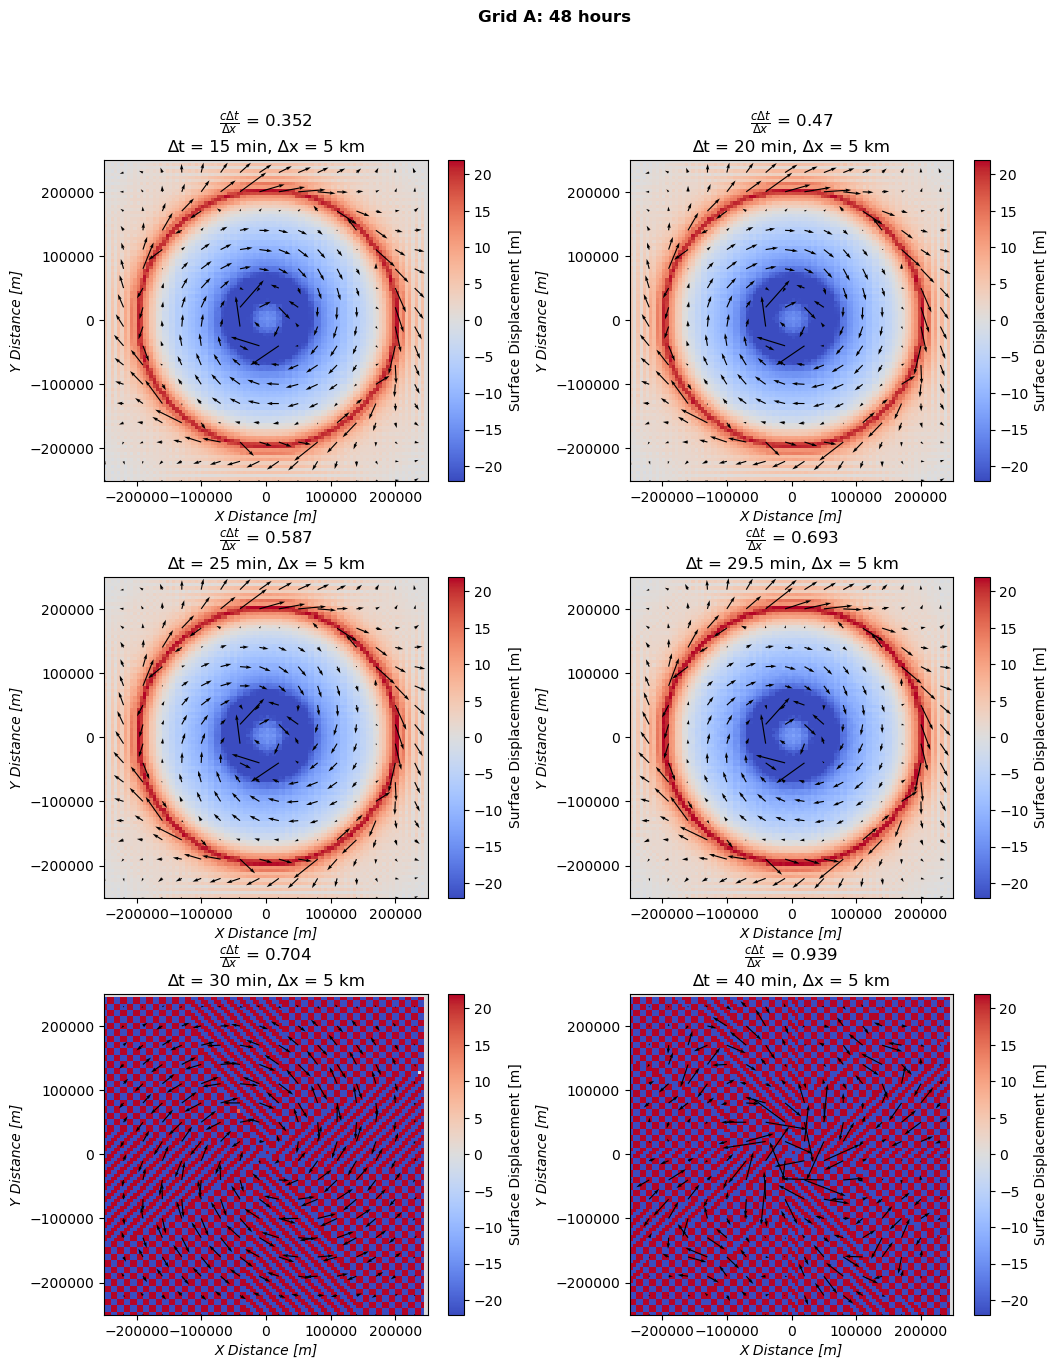

In [174]:
fig, axarr = plt.subplots(nrows = 3, ncols = 2, figsize = [12,15])
axarr = axarr.flatten()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# dt = 15 min
ax = axarr[0]
im = ax.pcolormesh(x,y,h15[:,:], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u15[::M,::M], v15[::M,::M])
gp = 9.8 * (1024-1020)/1024
H = 100
dt = 60*15
dx = 5000
c = np.sqrt(gp * H)
CFL = c * dt/dx
ax.set_title(r'$\frac{c\Delta t}{\Delta x}$ = ' + str(round(CFL,3)) + '\n∆t = 15 min, ∆x = 5 km')
cbar.set_label('Surface Displacement [m]')

# dt = 20 min
ax = axarr[1]
im = ax.pcolormesh(x,y,h20[:,:], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u20[::M,::M], v20[::M,::M])
gp = 9.8 * (1024-1020)/1024
H = 100
dt = 60*20
dx = 5000
c = np.sqrt(gp * H)
CFL = c * dt/dx
ax.set_title(r'$\frac{c\Delta t}{\Delta x}$ = ' + str(round(CFL,3)) + '\n∆t = 20 min, ∆x = 5 km')
cbar.set_label('Surface Displacement [m]')

# dt = 25 min
ax = axarr[2]
im = ax.pcolormesh(x,y,h25[:,:], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u25[::M,::M], v25[::M,::M])
gp = 9.8 * (1024-1020)/1024
H = 100
dt = 60*25
dx = 5000
c = np.sqrt(gp * H)
CFL = c * dt/dx
ax.set_title(r'$\frac{c\Delta t}{\Delta x}$ = ' + str(round(CFL,3)) + '\n∆t = 25 min, ∆x = 5 km')
cbar.set_label('Surface Displacement [m]')

# dt = 28 min
ax = axarr[3]
im = ax.pcolormesh(x,y,h29[:,:], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u29[::M,::M], v29[::M,::M])
gp = 9.8 * (1024-1020)/1024
H = 100
dt = 60*29.5
dx = 5000
c = np.sqrt(gp * H)
CFL = c * dt/dx
ax.set_title(r'$\frac{c\Delta t}{\Delta x}$ = ' + str(round(CFL,3)) + '\n∆t = 29.5 min, ∆x = 5 km')
cbar.set_label('Surface Displacement [m]')

# dt = 30 min
ax = axarr[4]
im = ax.pcolormesh(x,y,h30[:,:], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u30[::M,::M], v30[::M,::M])
gp = 9.8 * (1024-1020)/1024
H = 100
dt = 60*30
dx = 5000
c = np.sqrt(gp * H)
CFL = c * dt/dx
ax.set_title(r'$\frac{c\Delta t}{\Delta x}$ = ' + str(round(CFL,3)) + '\n∆t = 30 min, ∆x = 5 km')
cbar.set_label('Surface Displacement [m]')

# dt = 40 min
ax = axarr[5]
im = ax.pcolormesh(x,y,h40[:,:], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u40[::M,::M], v40[::M,::M])
gp = 9.8 * (1024-1020)/1024
H = 100
dt = 60*40
dx = 5000
c = np.sqrt(gp * H)
CFL = c * dt/dx
ax.set_title(r'$\frac{c\Delta t}{\Delta x}$ = ' + str(round(CFL,3)) + '\n∆t = 40 min, ∆x = 5 km')
cbar.set_label('Surface Displacement [m]')

for ax in axarr:
    ax.set_xlabel('X Distance [m]', fontstyle = 'italic')
    ax.set_ylabel('Y Distance [m]', fontstyle = 'italic')
    
fig.suptitle('Grid A: 48 hours', fontweight = 'bold')
fig.savefig('GridA_stability_24hr.png', bbox_inches='tight')

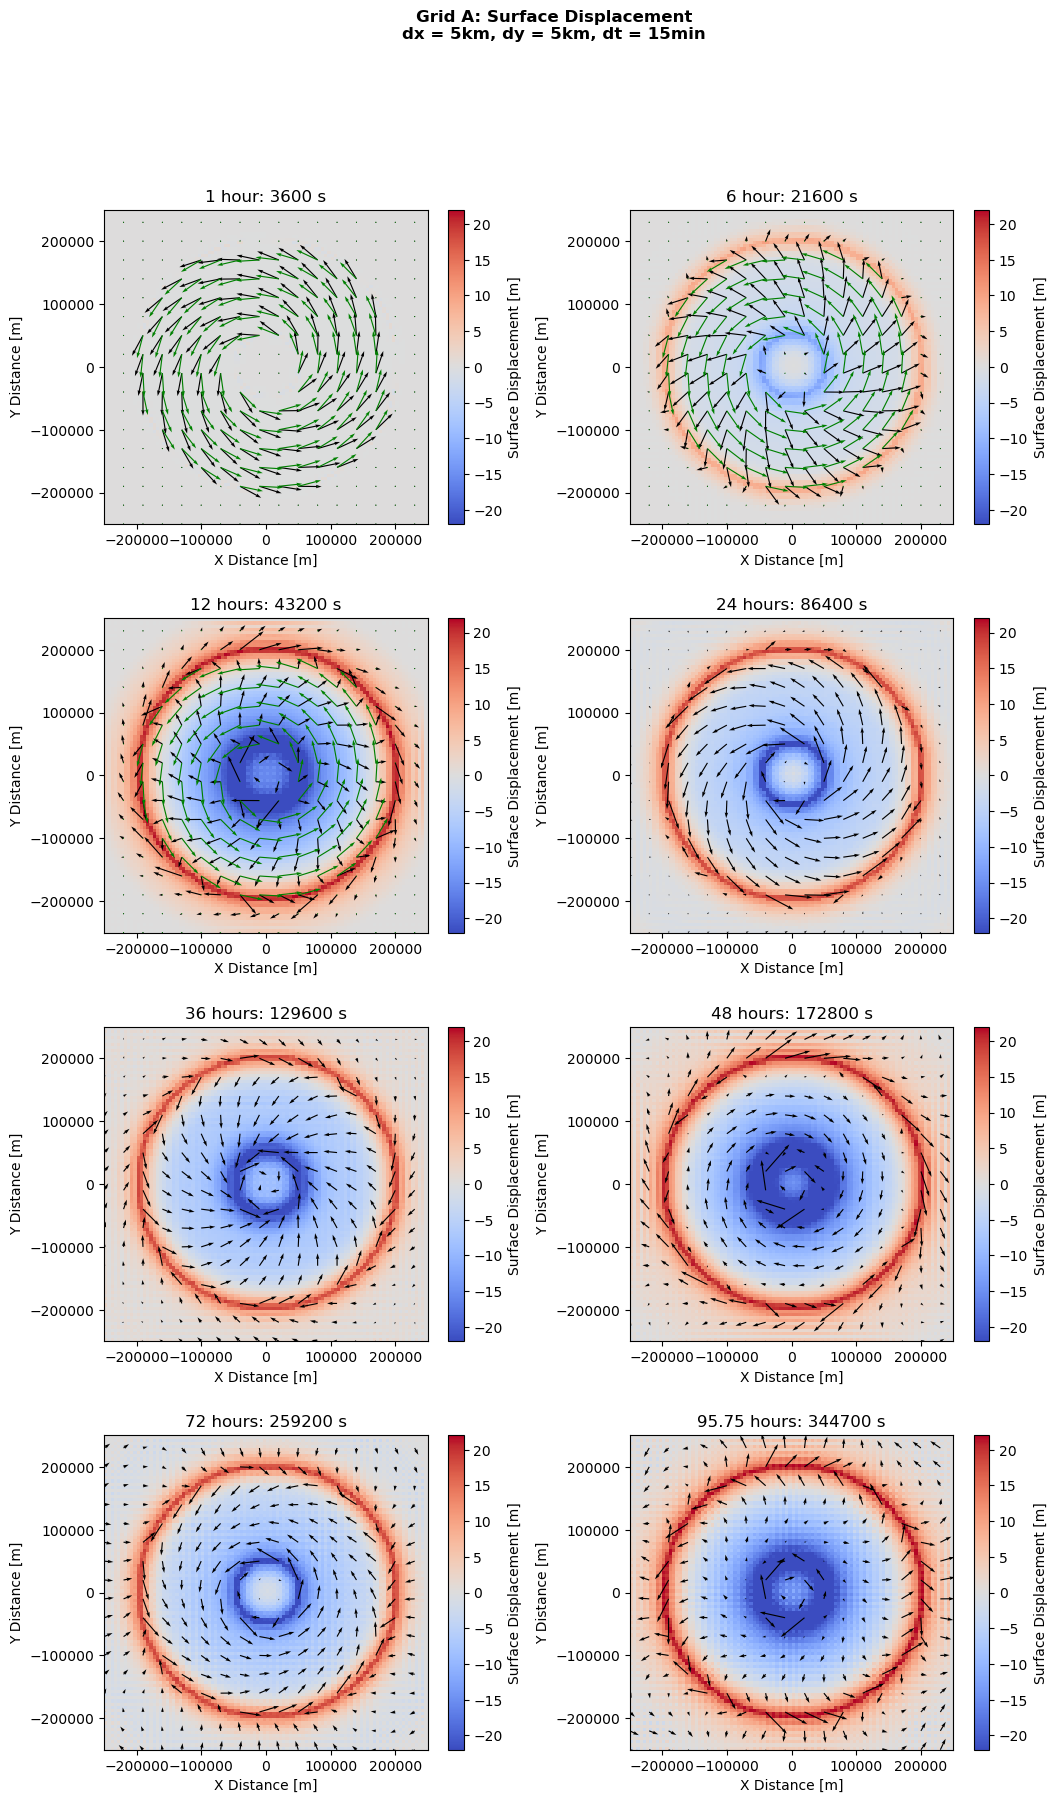

In [210]:
fig, axarr = plt.subplots(nrows = 4, ncols = 2, figsize = [12,20])
axarr = axarr.flatten()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# 1 hour
ax = axarr[0]
T = t[4]
im = ax.pcolormesh(x,y,h_A[:,:,4], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u_A[::M,::M,4], v_A[::M,::M,4])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,4], tau_y[::M,::M,4], color = 'g')
ax.set_title('1 hour: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

# 6 hour
ax = axarr[1]
T = t[4*6]
im = ax.pcolormesh(x,y,h_A[:,:,4*6], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u_A[::M,::M,4*6], v_A[::M,::M,4*6])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,4*6], tau_y[::M,::M,4*6], color = 'g')
ax.set_title('6 hour: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

# 12 hour
ax = axarr[2]
T = t[4*12]
im = ax.pcolormesh(x,y,h_A[:,:,4*12], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u_A[::M,::M,4*12], v_A[::M,::M,4*12])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,4*12], tau_y[::M,::M,4*12], color = 'g')
ax.set_title('12 hours: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

# 24 hour
ax = axarr[3]
T = t[4*24]
im = ax.pcolormesh(x,y,h_A[:,:,4*24], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u_A[::M,::M,4*24], v_A[::M,::M,4*24])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,4*24], tau_y[::M,::M,4*24], color = 'g')
ax.set_title('24 hours: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

# 36 hour
ax = axarr[4]
T = t[4*36]
im = ax.pcolormesh(x,y,h_A[:,:,4*36], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u_A[::M,::M,4*36], v_A[::M,::M,4*36])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,4*36], tau_y[::M,::M,4*36], color = 'g')
ax.set_title('36 hours: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

# 48 hour
ax = axarr[5]
T = t[4*48]
im = ax.pcolormesh(x,y,h_A[:,:,4*48], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u_A[::M,::M,4*48], v_A[::M,::M,4*48])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,4*48], tau_y[::M,::M,4*48], color = 'g')
ax.set_title('48 hours: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

# 72 hour
ax = axarr[6]
T = t[4*72]
im = ax.pcolormesh(x,y,h_A[:,:,4*72], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u_A[::M,::M,4*72], v_A[::M,::M,4*72])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,4*72], tau_y[::M,::M,4*72], color = 'g')
ax.set_title('72 hours: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

# 95.75 hour
ax = axarr[7]
T = t[-1]
im = ax.pcolormesh(x,y,h_A[:,:,-1], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u_A[::M,::M,-1], v_A[::M,::M,-1])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,-1], tau_y[::M,::M,-1], color = 'g')
ax.set_title('95.75 hours: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

for ax in axarr:
    ax.set_xlabel('X Distance [m]')
    ax.set_ylabel('Y Distance [m]')
    
fig.suptitle('Grid A: Surface Displacement\ndx = 5km, dy = 5km, dt = 15min', fontweight = 'bold')
fig.savefig('GridA_h_dx5000m_dt5min_96hr.png', bbox_inches='tight')

# Grid C

In [196]:
dt = 60*15 # 15 minute
t_end = 86400 * 4 # 4 days
t = np.arange(0,t_end,dt)

# i and j index to 500
ilen = 100
i = np.arange(0,ilen,1)
i_half = np.arange(0.5,ilen,1)
j = np.arange(0,ilen,1)
j_half = np.arange(0.5,ilen,1)

dx = 5000
x = np.arange(-(len(i)*dx)/2,(len(i)*dx)/2 + dx,dx)
x_half = np.arange(-(len(i)*dx)/2,(len(i)*dx)/2 + dx,dx) + round(np.diff(x).mean())/2

dy = 5000
y = np.arange(-(len(j)*dy)/2,(len(j)*dy)/2 + dy,dy)
y_half = np.arange(-(len(j)*dy)/2,(len(j)*dy)/2 + dy,dy) + round(np.diff(y).mean())/2

u = np.zeros((len(i), len(j), len(t)))
v = np.zeros((len(i), len(j), len(t)))
h = np.zeros((len(i), len(j), len(t)))

tau_x = np.zeros((len(i), len(j), len(t)))
tau_y = np.zeros((len(i), len(j), len(t)))

rm = 50*1e3 # meters
r0 = 200e3
taum = 2
for I,value in enumerate(tau_x):
    for J,val in enumerate(value):
        for N,T in enumerate(val):
            time = t[N]
            if time <= 86400/2: # if T is less than 12 hours
                X = x[I]
                Y = y[J]
                R = np.sqrt(X**2+Y**2) # check if radius is less than r0
                if (R < r0) & (R >= rm): # if radius less than r0
                    coeff = (R - r0)/(R - r0)
                    tau = coeff * taum
                    theta = np.arctan2(Y,X)
                    taux = tau * -np.cos(theta)
                        
                    tau_x[I,J,N] = taux
                else:
                    # if radius is longer than r0, tau_x is 0
                    tau_x[I,J,N] = 0
            else:
                # if time is greater than 12 hours tau_x is 0
                tau_x[I,J,N] = 0
                
                
for I,value in enumerate(tau_y):
    for J,val in enumerate(value):
        for N,T in enumerate(val):
            time = t[N]
            if time <= 86400/2: # if T is less than 12 hours
                X = x[I]
                Y = y[J]
                R = np.sqrt(X**2+Y**2) # check if radius is less than r0
                if (R < r0) & (R >= rm): # if radius less than r0
                    coeff = (R - r0)/(R - r0)
                    tau = coeff * taum
                    theta = np.arctan2(Y,X)
                    tauy = tau * np.sin(theta)
                        
                    tau_y[I,J,N] = tauy
                else:
                    # if radius is longer than r0, tau_y is 0
                    tau_y[I,J,N] = 0
            else:
                # if time is greater than 12 hours tau_y is 0
                tau_y[I,J,N] = 0
                

In [197]:
gp = 9.8 * (1024-1020)/1024
H = 100
p = 1020
f = 10**(-4)
dx = 5000
dy = 5000
for n,T in enumerate(t):
    # print(T)
    for I,i_val in enumerate(i):
        for J,j_val in enumerate(j):
            if I < i.max():
                if n < len(t)-1:
                    if J < j.max():
                        I_half = I
                        J_half = J
                        i_half_val = i_half[I_half]
                        j_half_val = j_half[J_half]
                        
                        # SOLVING FOR U **************************************************
                        # VBAR: spatially average v in both x and y direction such that v is now located at half i and whole j
                        vbar = 0.5 * ( ( (v[J_half,I+1,n] + v[J_half-1,I+1,n]) /2 ) + ( (v[J_half,I,n] + v[J_half-1,I,n])/2 ) )
                        
                        # TAUX: spatially average taux in x direction such that taux is now located at half i and whole j...
                        # ...as opposed to native coords of whole i and whole j
                        TAUX = (tau_x[J,I,n] + tau_x[J,I+1,n])/2      # tau_x[i+1/2,j,n] = (tau_x[i,j,n] + tau_x[i+1,j,n])/2
                        dhdx = (h[J,I+1,n] - h[J,I,n])/dx             # dhdx[i+1/2,j,n]
                        
                        # u[n+1] = -2∆tg' * dhdx + 2∆t/(Hp) * tau_x + 2∆tfv + u[n-1]
                        u[J,I_half,n+1] = (2 * -dt * gp * dhdx) + ((2*dt)/(H*p) * TAUX) + (vbar * f * dt*2) + u[J,I_half,n-1]
                    
                        # SOLVING FOR V **************************************************
                        # UBAR: spatially average u in both x and y direction such that u is now located at whole i and half j
                        # ubar[i,j+1/2] = [(u[i+1/2,j+1] + u[i+1/2,j])/2 + (u[i-1/2,j+1] + u[i-1/2,j])/2]/2
                        ubar = 0.5 * ( ( (u[J+1,I_half,n] + u[J,I_half,n]) /2 ) + ( (u[J+1,I_half-1,n] + u[J,I_half-1,n]) /2 ) )
                        
                        # TAUY: spatially average tauy in y direction such that tauy is now located at whole i and half j...
                        # ...as opposed to native coords of whole i and whole j
                        TAUY = (tau_y[J,I,n] + tau_y[J+1,I,n])/2      # tau_y[i,j+1/2,n] = (tau_y[i,j,n] + tau_y[i,j+1,n])/2
                        dhdy = (h[J+1,I,n] - h[J,I,n])/dy             # dhdy[i,j+1/2,n]
                        # v[n+1] = -2∆tg' * dhdy + 2∆t/(Hp) * tau_y - 2∆tfu + v[n-1]
                        v[J_half,I,n+1] = (-dt*2 * gp * dhdy) + ((dt*2)/(H*p) * TAUY) - (ubar * f * dt*2) + v[J_half,I,n-1]
                    
                        # SOLVING FOR h **************************************************
                        dudx = (u[J,I_half,n] - u[J,I_half-1,n])/dx      # (u[i+1/2,j,n] - u[i-1/2,j,n])/dx
                        dvdy = (v[J_half,I,n] - v[J_half-1,I,n])/dy      # (v[i,j+1/2,n] - v[i,j-1/2,n])/dy
                        # h[n+1] = -2∆tH * (dudx + dvdy) + h[n-1]
                        h[J,I,n+1] = h[J,I,n-1] - (2*dt * H) * ( dudx + dvdy )  

In [177]:
u15_C = u[:,:,int(172800/15/60)]
v15_C = v[:,:,int(172800/15/60)]
h15_C = h[:,:,int(172800/15/60)]

In [180]:
u20_C = u[:,:,int(172800/20/60)]
v20_C = v[:,:,int(172800/20/60)]
h20_C = h[:,:,int(172800/20/60)]

In [188]:
u16_C = u[:,:,int(172800/16/60)]
v16_C = v[:,:,int(172800/16/60)]
h16_C = h[:,:,int(172800/16/60)]

In [192]:
u10_C = u[:,:,int(172800/10/60)]
v10_C = v[:,:,int(172800/10/60)]
h10_C = h[:,:,int(172800/10/60)]

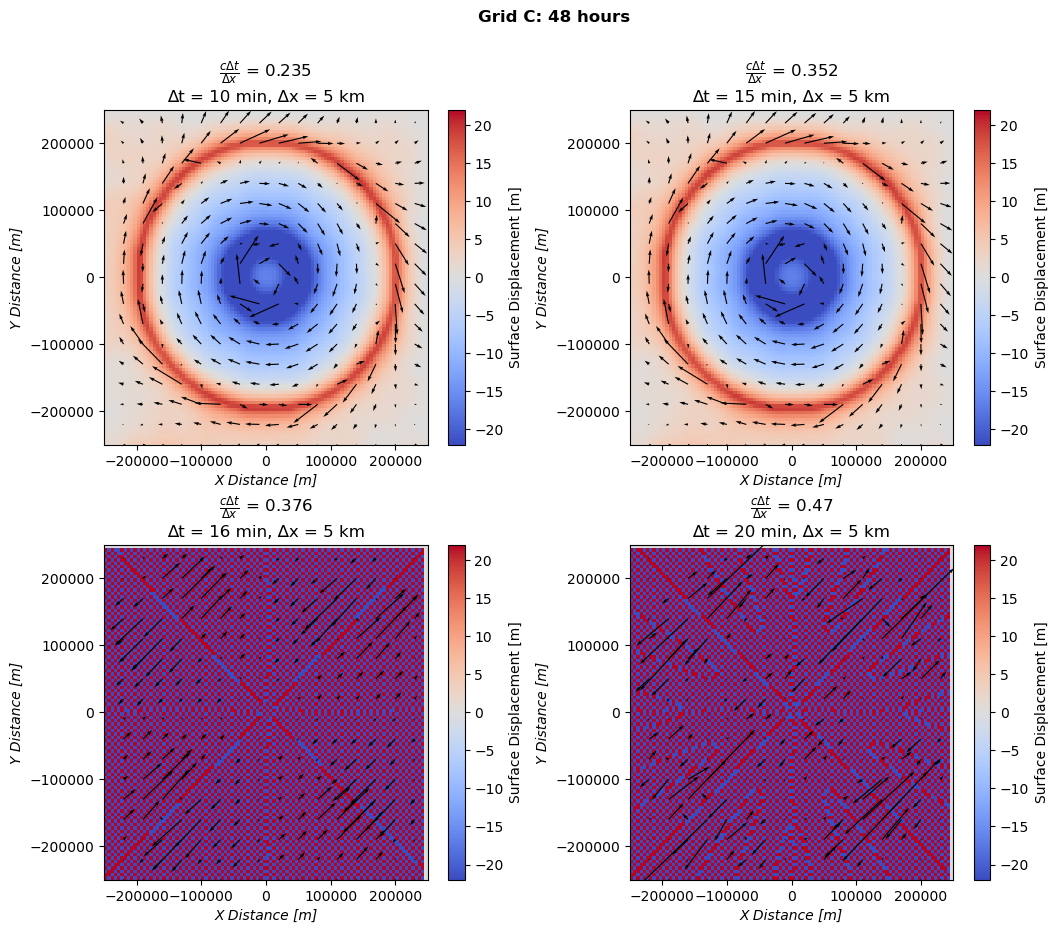

In [195]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [12,10])
axarr = axarr.flatten()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# dt = 15 min
ax = axarr[1]
im = ax.pcolormesh(x,y,h15_C[:,:], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u15_C[::M,::M], v15_C[::M,::M])
gp = 9.8 * (1024-1020)/1024
H = 100
dt = 60*15
dx = 5000
c = np.sqrt(gp * H)
CFL = c * dt/dx
ax.set_title(r'$\frac{c\Delta t}{\Delta x}$ = ' + str(round(CFL,3)) + '\n∆t = 15 min, ∆x = 5 km')
cbar.set_label('Surface Displacement [m]')

# dt = 20 min
ax = axarr[3]
im = ax.pcolormesh(x,y,h20_C[:,:], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u20_C[::M,::M], v20_C[::M,::M])
gp = 9.8 * (1024-1020)/1024
H = 100
dt = 60*20
dx = 5000
c = np.sqrt(gp * H)
CFL = c * dt/dx
ax.set_title(r'$\frac{c\Delta t}{\Delta x}$ = ' + str(round(CFL,3)) + '\n∆t = 20 min, ∆x = 5 km')
cbar.set_label('Surface Displacement [m]')

# dt = 16 min
ax = axarr[2]
im = ax.pcolormesh(x,y,h16_C[:,:], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u16_C[::M,::M], v16_C[::M,::M])
gp = 9.8 * (1024-1020)/1024
H = 100
dt = 60*16
dx = 5000
c = np.sqrt(gp * H)
CFL = c * dt/dx
ax.set_title(r'$\frac{c\Delta t}{\Delta x}$ = ' + str(round(CFL,3)) + '\n∆t = 16 min, ∆x = 5 km')
cbar.set_label('Surface Displacement [m]')

# dt = 10 min
ax = axarr[0]
im = ax.pcolormesh(x,y,h10_C[:,:], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u10_C[::M,::M], v10_C[::M,::M])
gp = 9.8 * (1024-1020)/1024
H = 100
dt = 60*10
dx = 5000
c = np.sqrt(gp * H)
CFL = c * dt/dx
ax.set_title(r'$\frac{c\Delta t}{\Delta x}$ = ' + str(round(CFL,3)) + '\n∆t = 10 min, ∆x = 5 km')
cbar.set_label('Surface Displacement [m]')

for ax in axarr:
    ax.set_xlabel('X Distance [m]', fontstyle = 'italic')
    ax.set_ylabel('Y Distance [m]', fontstyle = 'italic')
    
fig.suptitle('Grid C: 48 hours', fontweight = 'bold')
fig.savefig('GridC_stability_48hr.png', bbox_inches='tight')

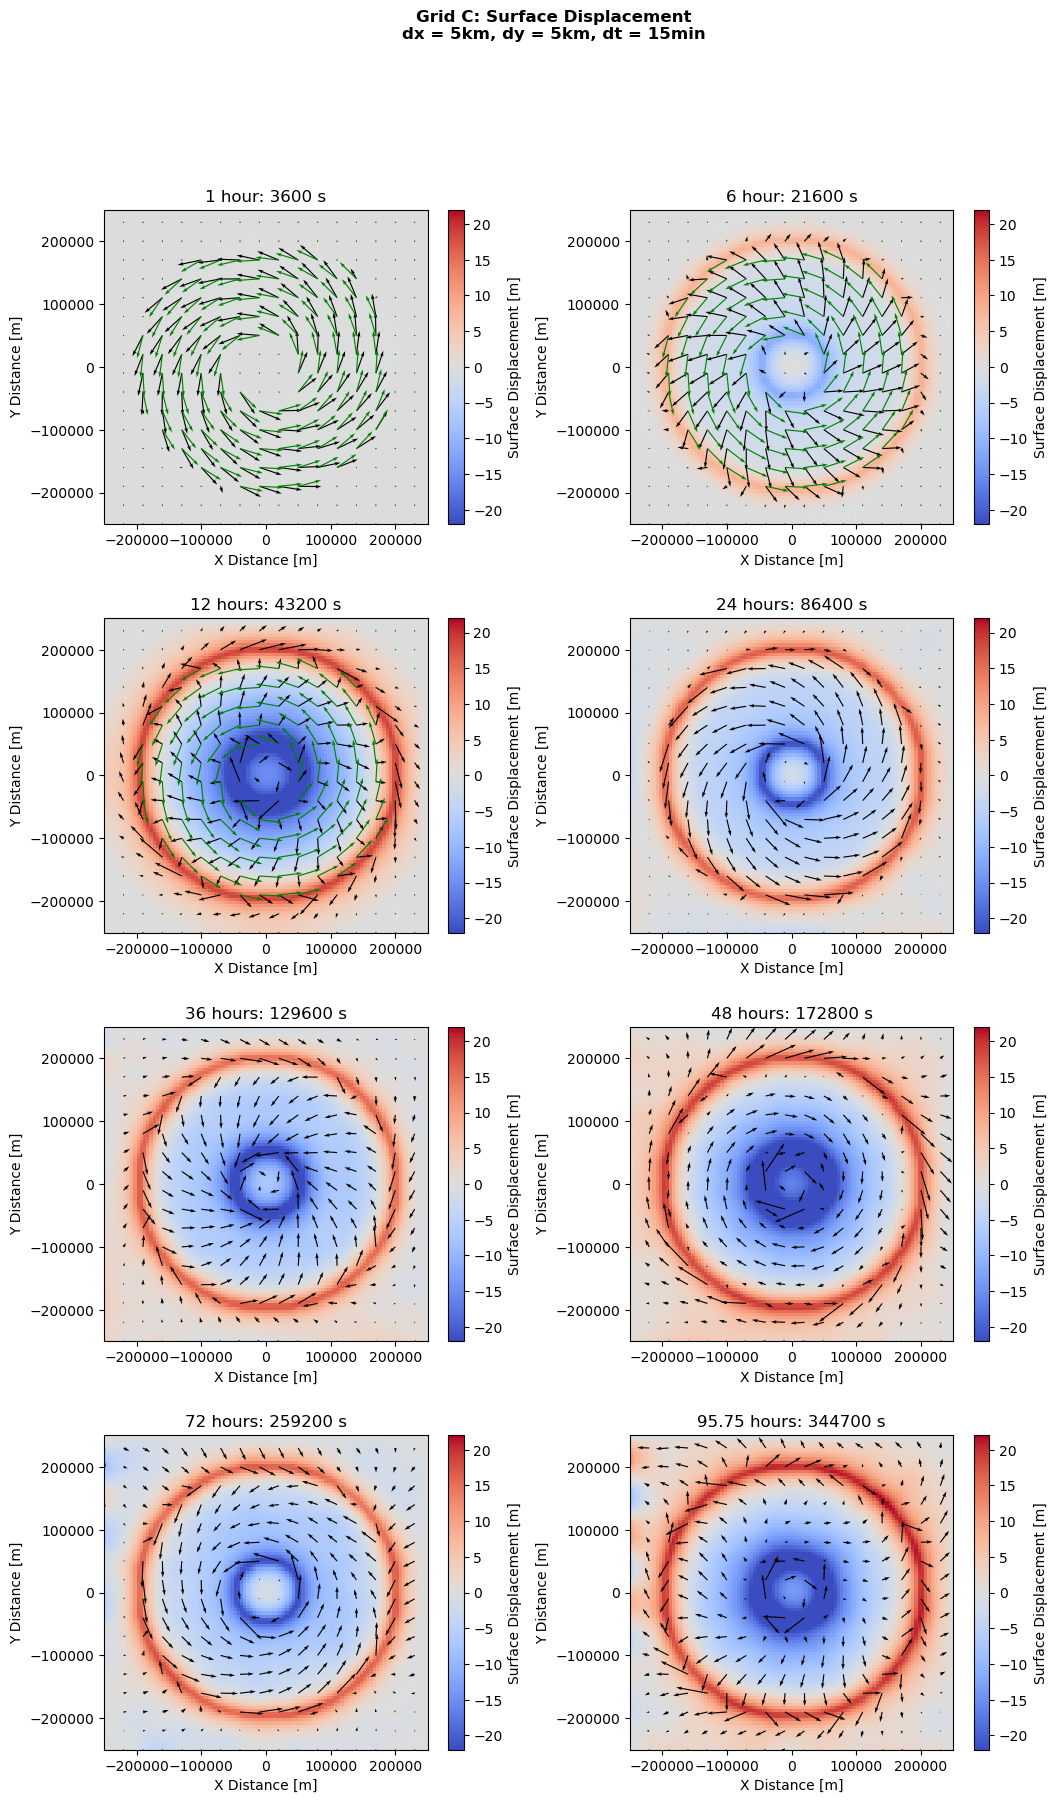

In [206]:
fig, axarr = plt.subplots(nrows = 4, ncols = 2, figsize = [12,20])
axarr = axarr.flatten()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# 1 hour
ax = axarr[0]
T = t[4]
im = ax.pcolormesh(x,y,h[:,:,4], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u[::M,::M,4], v[::M,::M,4])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,4], tau_y[::M,::M,4], color = 'g')
ax.set_title('1 hour: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

# 6 hour
ax = axarr[1]
T = t[4*6]
im = ax.pcolormesh(x,y,h[:,:,4*6], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u[::M,::M,4*6], v[::M,::M,4*6])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,4*6], tau_y[::M,::M,4*6], color = 'g')
ax.set_title('6 hour: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

# 12 hour
ax = axarr[2]
T = t[4*12]
im = ax.pcolormesh(x,y,h[:,:,4*12], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u[::M,::M,4*12], v[::M,::M,4*12])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,4*12], tau_y[::M,::M,4*12], color = 'g')
ax.set_title('12 hours: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

# 24 hour
ax = axarr[3]
T = t[4*24]
im = ax.pcolormesh(x,y,h[:,:,4*24], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u[::M,::M,4*24], v[::M,::M,4*24])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,4*24], tau_y[::M,::M,4*24], color = 'g')
ax.set_title('24 hours: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

# 36 hour
ax = axarr[4]
T = t[4*36]
im = ax.pcolormesh(x,y,h[:,:,4*36], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u[::M,::M,4*36], v[::M,::M,4*36])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,4*36], tau_y[::M,::M,4*36], color = 'g')
ax.set_title('36 hours: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

# 48 hour
ax = axarr[5]
T = t[4*48]
im = ax.pcolormesh(x,y,h[:,:,4*48], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u[::M,::M,4*48], v[::M,::M,4*48])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,4*48], tau_y[::M,::M,4*48], color = 'g')
ax.set_title('48 hours: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

# 72 hour
ax = axarr[6]
T = t[4*72]
im = ax.pcolormesh(x,y,h[:,:,4*72], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u[::M,::M,4*72], v[::M,::M,4*72])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,4*72], tau_y[::M,::M,4*72], color = 'g')
ax.set_title('72 hours: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

# 95.75 hour
ax = axarr[7]
T = t[-1]
im = ax.pcolormesh(x,y,h[:,:,-1], cmap = 'coolwarm', vmin = -22, vmax = 22)
cbar = plt.colorbar(im, ax = ax)
xx = x[:-1]
yy = y[:-1]
M = 6
ax.quiver(x[::M], y[::M], u[::M,::M,-1], v[::M,::M,-1])
ax.quiver(x[::M], y[::M], tau_x[::M,::M,-1], tau_y[::M,::M,-1], color = 'g')
ax.set_title('95.75 hours: ' + str(T) + ' s')
cbar.set_label('Surface Displacement [m]')

for ax in axarr:
    ax.set_xlabel('X Distance [m]')
    ax.set_ylabel('Y Distance [m]')
    
fig.suptitle('Grid C: Surface Displacement\ndx = 5km, dy = 5km, dt = 15min', fontweight = 'bold')
fig.savefig('GridC_h_dx5000m_dt5min_96hr.png', bbox_inches='tight')

In [26]:
np.interp(x,x_half,u[])

Help on function interp in module numpy:

interp(x, xp, fp, left=None, right=None, period=None)
    One-dimensional linear interpolation for monotonically increasing sample points.
    
    Returns the one-dimensional piecewise linear interpolant to a function
    with given discrete data points (`xp`, `fp`), evaluated at `x`.
    
    Parameters
    ----------
    x : array_like
        The x-coordinates at which to evaluate the interpolated values.
    
    xp : 1-D sequence of floats
        The x-coordinates of the data points, must be increasing if argument
        `period` is not specified. Otherwise, `xp` is internally sorted after
        normalizing the periodic boundaries with ``xp = xp % period``.
    
    fp : 1-D sequence of float or complex
        The y-coordinates of the data points, same length as `xp`.
    
    left : optional float or complex corresponding to fp
        Value to return for `x < xp[0]`, default is `fp[0]`.
    
    right : optional float or complex co

In [90]:
from scipy.interpolate import interpn
points = (y[:-1], x_half[:-1])
newpoints = (y[:-1],np.append(x[1:-1],247500))
UNEW = interpn(points, u[:,:,:], newpoints)

points = (y_half[:-1], x[:-1])
newpoints = (np.append(y[1:-1],247500),:)
VNEW = interpn(points, v[:,:,:], newpoints)

SyntaxError: invalid syntax (781189260.py, line 7)

In [88]:
VNEW.shape

(100, 384)

In [82]:
UNEW

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  9.09645676e-12,  2.16995850e-06, -1.42894738e-03,
       -9.94087581e-03,  2.34169964e-03,  7.07878400e-02,  5.51286424e-02,
        5.04329631e-02,  5.03186245e-02,  5.04745362e-02,  5.06446134e-02,
        5.08308654e-02,  5.10357087e-02,  5.12620654e-02,  5.15135017e-02,
        5.17944151e-02,  5.21102907e-02,  5.24680579e-02,  5.28765962e-02,
        5.33474692e-02,  5.38960122e-02,  5.45429925e-02,  5.53164238e-02,
        5.76816643e-02,  6.60217178e-02,  8.05853403e-02, -2.77029332e-02,
       -8.84272013e-03, -1.07716602e-03,  1.19643746e-06,  3.88138108e-12,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -5.26503347e-12, -

In [42]:
from scipy.interpolate import LinearNDInterpolator


# rng = np.random.default_rng()

# x = rng.random(10) - 0.5

# y = rng.random(10) - 0.5

# z = np.hypot(x, y)

# X = np.linspace(min(x), max(x))

# Y = np.linspace(min(y), max(y))

# X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation

# interp = LinearNDInterpolator(list(zip(y, x_half)), u[:,:,0])
interp = LinearNDInterpolator((y, x_half), u[:,:,0])
interp(y, x)

ValueError: different number of values and points

In [40]:
list(zip(y, x_half))

[(-250000.0, -247500.0),
 (-245000.0, -242500.0),
 (-240000.0, -237500.0),
 (-235000.0, -232500.0),
 (-230000.0, -227500.0),
 (-225000.0, -222500.0),
 (-220000.0, -217500.0),
 (-215000.0, -212500.0),
 (-210000.0, -207500.0),
 (-205000.0, -202500.0),
 (-200000.0, -197500.0),
 (-195000.0, -192500.0),
 (-190000.0, -187500.0),
 (-185000.0, -182500.0),
 (-180000.0, -177500.0),
 (-175000.0, -172500.0),
 (-170000.0, -167500.0),
 (-165000.0, -162500.0),
 (-160000.0, -157500.0),
 (-155000.0, -152500.0),
 (-150000.0, -147500.0),
 (-145000.0, -142500.0),
 (-140000.0, -137500.0),
 (-135000.0, -132500.0),
 (-130000.0, -127500.0),
 (-125000.0, -122500.0),
 (-120000.0, -117500.0),
 (-115000.0, -112500.0),
 (-110000.0, -107500.0),
 (-105000.0, -102500.0),
 (-100000.0, -97500.0),
 (-95000.0, -92500.0),
 (-90000.0, -87500.0),
 (-85000.0, -82500.0),
 (-80000.0, -77500.0),
 (-75000.0, -72500.0),
 (-70000.0, -67500.0),
 (-65000.0, -62500.0),
 (-60000.0, -57500.0),
 (-55000.0, -52500.0),
 (-50000.0, -47500.